# COVID-19 Mortality Rate Between Countries With Low and High Smoking Rate


## Introduction
At the end of 2019, the world witnessed a horrible news about the advent of a newly found yet deadly disease, Coronavirus disease (COVID-19). COVID-19  is a contagious disease that is caused by SARS-CoV-2, the severe acute respiratory syndrome coronavirus2. The first case was found in Wuhan, China, and quickly spread throughout the globe, leading to the COVID-19 pandemic. Common symtomps of COVID-19 vary, but usually include cough, fever, breathing difficulties, taste loss, smell loss. Many cases experienced critical symtomps like respiratory failure, multiorgan dysfunction, and ultimately decease. Several vaccines have been timely developed to contain the spread of this disease worldwide. Today we will look into the  situation of smoking rates and COVID-19 in several countries around the world. We will try to answer the question that does countries with high smoking rates have higher mortality rate of COVID-19 than countries with low smoking rates? We will look in to the mean of the death rate as our location parameter and the standard deviation of the death rate as our scale parameter.


## Preliminary Result

Now we take a look of the dataset. This dataset contains information about the COVID-19 pandemic that is updated daily by Our World in Data. It can be found under [this URL](https://github.com/owid/covid-19-data/tree/master/public/data). COVID-19 data recorded several aspects about the pandemic such as Confirmed cases, Confirm deaths, Hospital & ICU, Policy Responses, Vaccinations, etc. In this case, we will only examine:
- location: Countries.
- male_smokers: proportion of male smokers, most recent year possible.
- female_smokers: proportion of female smokers, most recent year possible.
- new_deaths: new deaths attributed to COVID-19 (within 7 days).
- new_cases : new confirmed cases attributed of COVID-19 (within 7 days).

With these information, we will transform the data to fit our objective of analysing the mortality rate and smoking rate.

First, we install libraries that are essential in implementing analysis and hypothesis testing.

In [2]:
library(tidyverse)
library(infer)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Next, we will use read.csv() to read the dataset owid-covid-data, and use head() to visualize what it looks like. We recognise many observations in "new_deaths" and "new_cases" columns with NA value. Also, the dataset will be filtered by Europe, America, and Oceania only since Asia has some errors. To simplify the process, we will transform NAs into 0, which indicates there were no new cases or deaths recorded on that day. Then, we tidy the data by sorting out all the NAs value in "male_smokers" and "female_smokers" columns, and grouped them by location. Since we are interested in the smoking rate of a country as a whole, we create a new column of smokers by taking the average of male smoker and female smokers. Consequently, we summarise the dataset by adding the mean smokers and mortality rate columns.

In [3]:
data <- read.csv("data/owid-covid-data.csv")
data["new_cases"][is.na(data["new_cases"])] <- 0
data["new_deaths"][is.na(data["new_deaths"])] <- 0
data_cleaned <- data %>% filter(!is.na(male_smokers)) %>% filter(!is.na(female_smokers)) %>% filter(continent %in% c("Europe", "America","Africa","Oceania")) %>%
        group_by(location) %>% 
        mutate(smokers = (male_smokers + female_smokers)/2) %>% group_by(location) %>% 
        summarise(mean_smokers = mean(smokers), mortality_rate = sum(new_deaths)/sum(new_cases))
head(data_cleaned)


location,mean_smokers,mortality_rate
<chr>,<dbl>,<dbl>
Albania,29.15,0.010794177
Algeria,15.55,0.025411492
Andorra,33.40,0.003380051
Australia,14.75,0.001467342
Austria,29.65,0.003889079
Belarus,28.30,0.007160699


We plot the distribution of mean smoking rate to determine the threshold to divide the countries into high and low smoking rate. As we observed from the graph that it is a little right-skewed, it is most reasonable to use the median as out cutoff. The median smoking rate is 23.3.

[1] 23.3

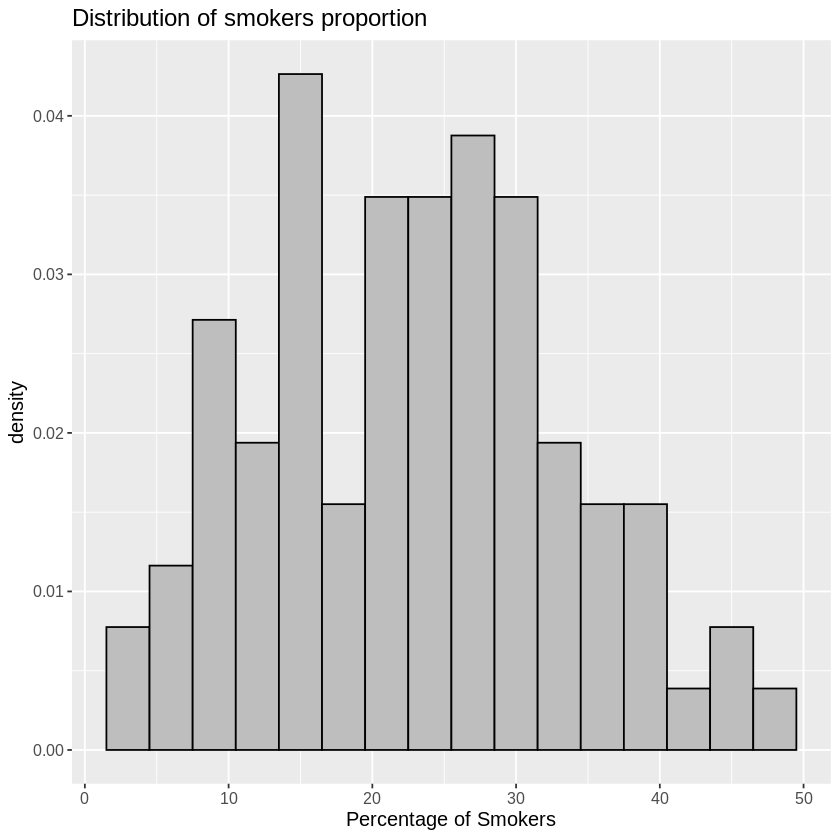

In [4]:
smokers_distri <- data_cleaned %>% ggplot(aes(x=mean_smokers, ..density..)) + geom_histogram(binwidth = 3, fill = "grey", color = "black") + labs(x = "Percentage of Smokers", title = "Distribution of smokers proportion") + 
        theme(text = element_text(size = 12))
smokers_distri
median(data_cleaned$mean_smokers)

To finalise our dataset, we create a new column indicates whether a country has high(> 23.3) or low smoking rate (<= 23.3). Only mortality rate and is_high_smoking_rate are kept in the final dataset.

In [10]:
data_final <- data_cleaned %>% mutate(is_high_smoking_rate = mean_smokers > 23.3) %>% select(-c(location, mean_smokers))
head(data_final) 

mortality_rate,is_high_smoking_rate
<dbl>,<lgl>
0.010794177,TRUE
0.025411492,FALSE
0.003380051,TRUE
0.001467342,FALSE
0.003889079,TRUE
0.007160699,TRUE


The next step is to divide the dataset into two parts corresponding to high or low smoking rate.

In [13]:
high_smoking_data <- data_final %>% filter(is_high_smoking_rate == "TRUE") %>% select(mortality_rate)
head(high_smoking_data)

low_smoking_data <- data_final %>% filter(is_high_smoking_rate == "FALSE") %>% select(mortality_rate)
head(low_smoking_data)

mortality_rate
<dbl>
0.010794177
0.003380051
0.003889079
0.007160699
0.007162074
0.040501623


mortality_rate
<dbl>
0.025411492
0.001467342
0.005823300
0.008549261
0.017890990
0.006586855


Next, we will estimate the population mean of mortality rate in high smoking rate countries by creating the sampling distribution of mean. First of all, we use `rep_sample_n()` to make 100000 samples of size 20. Then the population mean will be estimated at the center of the visualization of the sampling distribution. The population is approximately `0.012`.

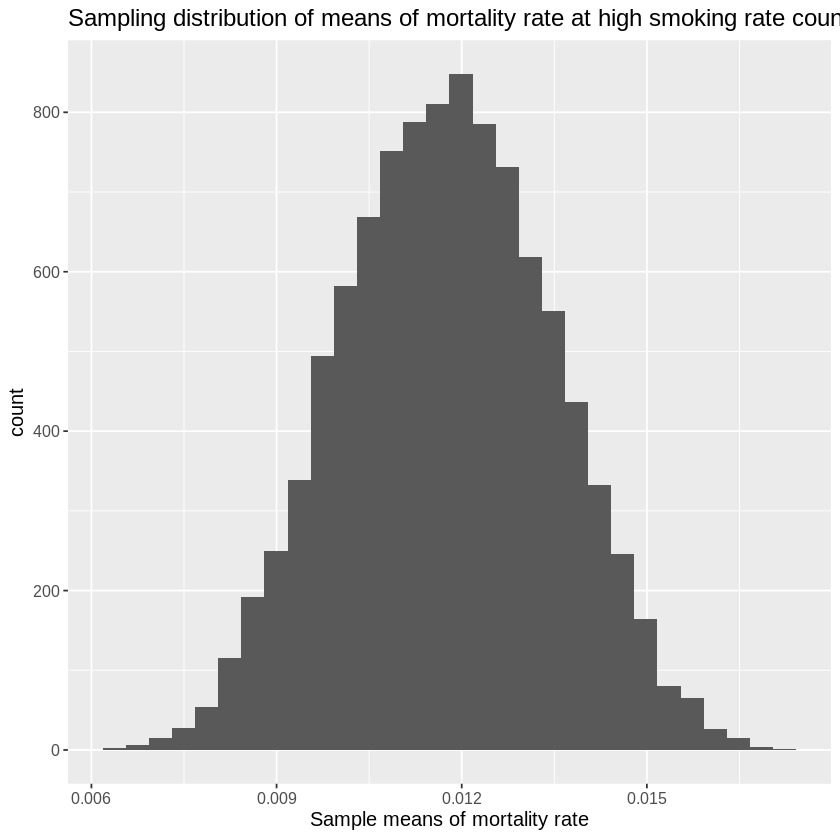

In [14]:
set.seed(2022)
high_smoking_sampling_distri <- high_smoking_data %>% rep_sample_n(size = 20, reps = 10000) %>%
                                group_by(replicate) %>% summarise(sample_mean = mean(mortality_rate))
high_smoking_sampling_plot <- high_smoking_sampling_distri %>% ggplot(aes(x = sample_mean)) + geom_histogram(bins = 30) + 
                              labs(x = "Sample means of mortality rate", title = "Sampling distribution of means of mortality rate at high smoking rate countries" ) +
                              theme(text = element_text(size = 12))
high_smoking_sampling_plot
mean_mortality_rate_highsmoking <- mean(high_smoking_sampling_distri$sample_mean)



Likewise, we will estimate the population mean of mortality rate in low smoking rate countries by creating the sampling distribution of mean. First of all, we use `rep_sample_n()` to make 100000 samples of size 20. Then the population mean will be estimated at the center of the visualization of the sampling distribution. The population is approximately `0.013`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



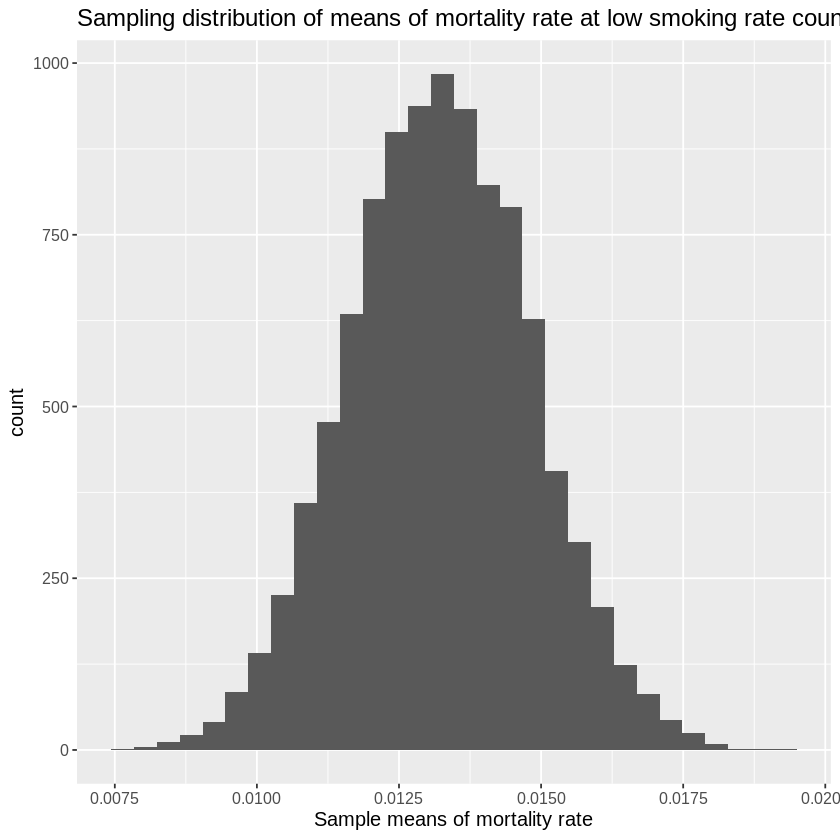

In [15]:
# set.seed(2022)
low_smoking_sampling_distri <- low_smoking_data %>% rep_sample_n(size = 20, reps = 10000, replace = F) %>%
                                group_by(replicate) %>% summarise(sample_mean = mean(mortality_rate))
low_smoking_sampling_plot <- low_smoking_sampling_distri %>% ggplot(aes(x = sample_mean)) + geom_histogram() + 
                              labs(x = "Sample means of mortality rate", title = "Sampling distribution of means of mortality rate at low smoking rate countries" ) +
                              theme(text = element_text(size = 12))
low_smoking_sampling_plot
mean_mortality_rate_lowsmoking <- mean(low_smoking_sampling_distri$sample_mean)


For the standard error, we will use `infer` package to make a bootstrap distribution of the mean mortality rate. Our standard error would be the spread of the bootstrap distribution's histogram. The standard error for mortality rate in high smoking rate countries is 0.0028.

se
<dbl>
0.002819303


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



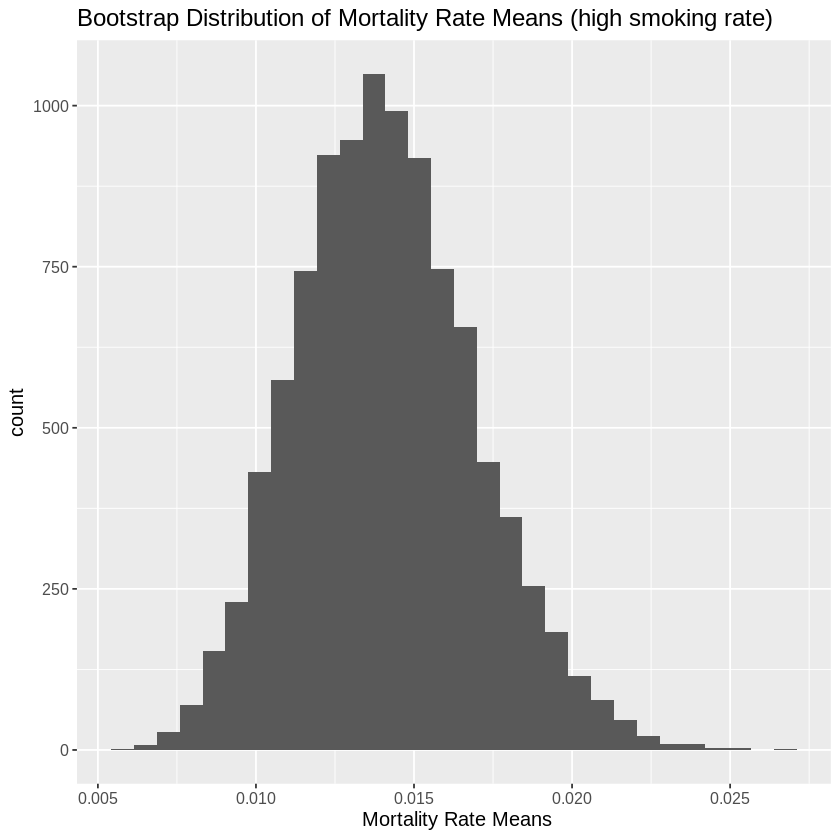

In [16]:
set.seed(2022)
high_smoking_sample <- high_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
high_smoking_bootstrap <- high_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")

high_smoking_se <- high_smoking_bootstrap %>% summarise(se = sd(stat))

high_smoking_data_vis <- high_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram() + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (high smoking rate)") + 
                        theme(text = element_text(size = 12))
high_smoking_data_vis

By the same token, the estimated standard error of mortality rate of low smoking rate countries is 0.0024

se
<dbl>
0.00237919


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



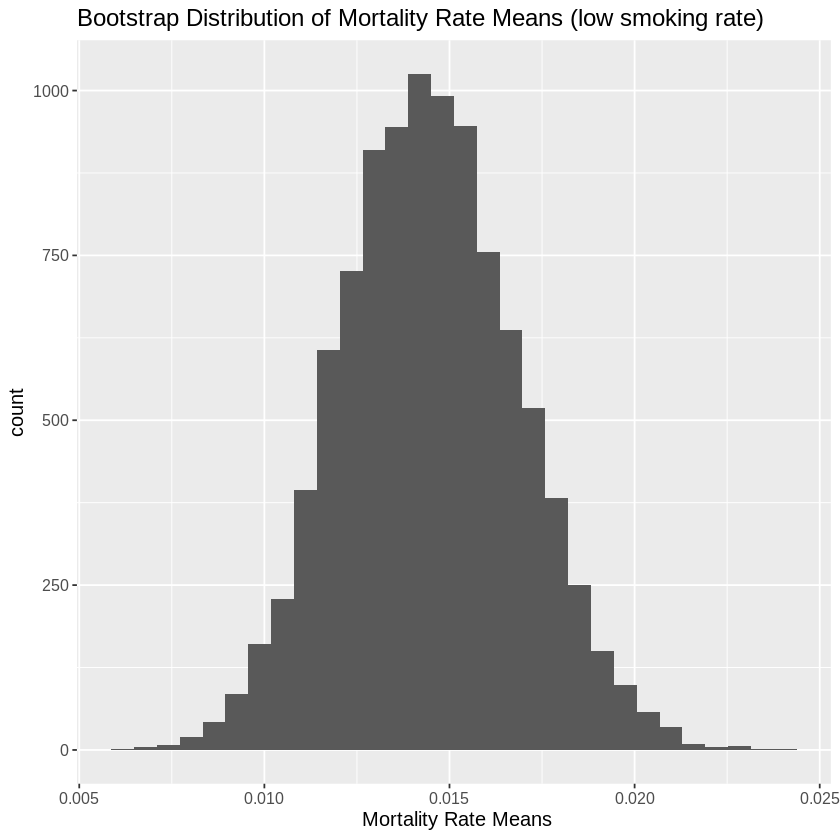

In [17]:
set.seed(2022)
low_smoking_sample<- low_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
low_smoking_bootstrap <- low_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")
low_smoking_se <- low_smoking_bootstrap %>% summarise(se = sd(stat))
low_smoking_se 
low_smoking_data_vis <- low_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram() + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (low smoking rate)") + 
                        theme(text = element_text(size = 12))
low_smoking_data_vis

Our final result is presented in the matrix below.

In [28]:
result <- tibble(mean_mortality_rate_highsmoking =0.012,
                 mean_mortality_rate_lowsmoking = 0.013,
                 se_mortality_rate_highsmoking = 0.0028,
                 se_mortality_rate_lowsmoking = 0.0024)
result

mean_mortality_rate_highsmoking,mean_mortality_rate_lowsmoking,se_mortality_rate_highsmoking,se_mortality_rate_lowsmoking
<dbl>,<dbl>,<dbl>,<dbl>
0.012,0.013,0.0028,0.0024
